In [1]:
import pandas as pd
from utils import dataframe_to_tensor, tensor_to_dataframe, clean_dataframe, plot_losses, combine_dataframes
import torch
import numpy as np
from IPython.display import display
import torch.nn as nn
from observer_gan import random_normal, train, train_wgan, random_model, save_models, load_models
import os
from eval import evaluate
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
num_positive_samples = 10 ** 5
num_unlabeled_samples = 10 ** 5
percent_unlabeled_positive = 0.9
positive_dataframe_train = pd.read_csv('poc_dataset/WalletSmartContract_poc_data_positive_train.csv')
positive_dataframe_train = positive_dataframe_train.sample(n=num_positive_samples)
clean_positive_dataframe_train = clean_dataframe(positive_dataframe_train)
unlabeled_dataframe_train_positive = pd.read_csv('poc_dataset/WalletSmartContract_poc_data_unlabeled_positive_train.csv')
unlabeled_dataframe_train_negative = pd.read_csv('poc_dataset/WalletSmartContract_poc_data_unlabeled_negative_train.csv')
unlabeled_dataframe_train = combine_dataframes(unlabeled_dataframe_train_positive, unlabeled_dataframe_train_negative, num_unlabeled_samples, percent_unlabeled_positive)
clean_unlabeled_dataframe_train = clean_dataframe(unlabeled_dataframe_train)
positive_tensor_train = dataframe_to_tensor(clean_positive_dataframe_train)
unlabeled_tensor_train = dataframe_to_tensor(clean_unlabeled_dataframe_train)


unlabeled_dataframe_test_positive = pd.read_csv('poc_dataset/WalletSmartContract_poc_data_unlabeled_positive_test.csv')
unlabeled_dataframe_test_negative = pd.read_csv('poc_dataset/WalletSmartContract_poc_data_unlabeled_negative_test.csv')

In [3]:
def eval_models(N):
    directory = 'models'
    all_models = list(os.listdir(directory))
    all_indexes = ['_'.join(model.split('_')[:-2]) for model in all_models]
    df = pd.DataFrame(columns=[f'auc_roc_{ii}' for ii in range(N)] + [f'ap_{ii}' for ii in range(N)], index=all_indexes, dtype=float)
    
    for filename in tqdm(all_models):
        if not os.path.isfile(os.path.join(directory, filename)):
            continue
        if 'discriminator' not in filename:
            continue
        if len(filename.split('_')[:-1]) != 4:
            continue
        n_epochs = 0
        n_samples_per_epoch = 5000
        hidden_size = 25
        hidden_layers = 4
        discriminator, generator, observer, _, _, _ = train(1e-3, n_epochs, positive_tensor_train, unlabeled_tensor_train, n_samples_per_epoch, hidden_size, hidden_size, hidden_size, hidden_layers, hidden_layers, hidden_layers)
        num_positive_samples, num_unlabeled_samples, percent_unlabeled_positive, ii = filename.split('_')[:-1]
        num_positive_samples, num_unlabeled_samples, percent_unlabeled_positive, ii = int(num_positive_samples), int(num_unlabeled_samples), float(percent_unlabeled_positive), int(ii)
        load_models(discriminator, generator, observer, f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}_{ii}')
        unlabeled_dataframe_test = combine_dataframes(unlabeled_dataframe_test_positive, unlabeled_dataframe_test_negative, None, percent_unlabeled_positive)
        clean_unlabeled_dataframe_test = clean_dataframe(unlabeled_dataframe_test)
        unlabeled_tensor_test = dataframe_to_tensor(clean_unlabeled_dataframe_test)

        labels = unlabeled_dataframe_test['positive'].astype(int)
        predicted = observer(unlabeled_tensor_test).detach().numpy().reshape(-1)
        observer_metrics = evaluate(predicted, labels, plot=False)
        df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'auc_roc_{ii}'] = observer_metrics['auc_roc']
        df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'ap_{ii}'] = observer_metrics['ap']
        # print(df)
    return df

In [4]:
def display_generator_samples(N, num_positive_samples, num_unlabeled_samples, percent_unlabeled_positive, num_samples):
    for ii in range(N):
        n_epochs = 0
        n_samples_per_epoch = 5000
        hidden_size = 25
        hidden_layers = 4
        discriminator, generator, observer, _, _, _ = train(1e-3, n_epochs, positive_tensor_train, unlabeled_tensor_train, n_samples_per_epoch, hidden_size, hidden_size, hidden_size, hidden_layers, hidden_layers, hidden_layers)
        load_models(discriminator, generator, observer, f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}_{ii}')
        print(f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}_{ii}')
        display(tensor_to_dataframe(generator(random_normal(num_samples, positive_tensor_train.shape[1])).detach(), clean_positive_dataframe_train))

In [5]:
def display_curves(num_positive_samples, num_unlabeled_samples, percent_unlabeled_positive, ii):
    n_epochs = 0
    n_samples_per_epoch = 5000
    hidden_size = 25
    hidden_layers = 4
    discriminator, generator, observer, _, _, _ = train(1e-3, n_epochs, positive_tensor_train, unlabeled_tensor_train, n_samples_per_epoch, hidden_size, hidden_size, hidden_size, hidden_layers, hidden_layers, hidden_layers)
    load_models(discriminator, generator, observer, f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}_{ii}')
    unlabeled_dataframe_test = combine_dataframes(unlabeled_dataframe_test_positive, unlabeled_dataframe_test_negative, None, percent_unlabeled_positive)
    clean_unlabeled_dataframe_test = clean_dataframe(unlabeled_dataframe_test)
    unlabeled_tensor_test = dataframe_to_tensor(clean_unlabeled_dataframe_test)
    labels = unlabeled_dataframe_test['positive'].astype(int)
    predicted = observer(unlabeled_tensor_test).detach().numpy().reshape(-1)
    observer_metrics = evaluate(predicted, labels, plot=True)

In [6]:
eval_df = eval_models(5)
eval_df.to_csv('eval_dataframe2.csv')

100%|██████████| 1128/1128 [13:06<00:00,  1.43it/s]


In [7]:
eval_df = pd.read_csv('eval_dataframe2.csv', index_col='Unnamed: 0')
# eval_df.index = eval_df.index.astype(str, copy = False)

In [8]:
positive_samples_params = [10 ** 2, 10 ** 3, 10 ** 4, 10 ** 5, 10 ** 6]
unlabeled_samples_params = [10 ** 2, 10 ** 3, 10 ** 4, 10 ** 5, 10 ** 6]
percent_unlabeled_positive_params = [0.99, 0.9, 0.75]

def plot_heatmap(N, percent_unlabeled_positive, metric):
    mean = np.zeros((len(positive_samples_params), len(unlabeled_samples_params)))
    std = np.zeros((len(positive_samples_params), len(unlabeled_samples_params)))
    for row, num_positive_samples in enumerate(positive_samples_params):
        for col, num_unlabeled_samples in enumerate(unlabeled_samples_params):
            numbers = np.zeros(N)
            for ii in range(N):
                numbers[ii] = eval_df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'{metric}_{ii}'][0]
            mean[row, col] = np.mean(numbers)
            std[row, col] = np.std(numbers)
            
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(mean, cmap='viridis', vmin=0, vmax=1, annot=False, fmt=".4f", cbar_kws={'label': f'Mean {metric}'}, yticklabels=positive_samples_params, xticklabels=unlabeled_samples_params)

    for i in range(len(positive_samples_params)):
        for j in range(len(unlabeled_samples_params)):
            text = f'{mean[i, j]:.4f}\n±{std[i, j]:.4f}'
            heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=15)

    plt.xlabel('Num Unlabeled Samples', fontsize=15)
    plt.ylabel('Num Positive Samples', fontsize=15)
    
    plt.title(f'Mean and std performance for {metric} at percent unlabeled positive {percent_unlabeled_positive}.', fontsize=15)
    plt.show()

/var/folders/mj/000gxq2x64vb9t9p3frbt_0c0000gn/T/ipykernel_21571/2450750814.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numbers[ii] = eval_df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'{metric}_{ii}'][0]


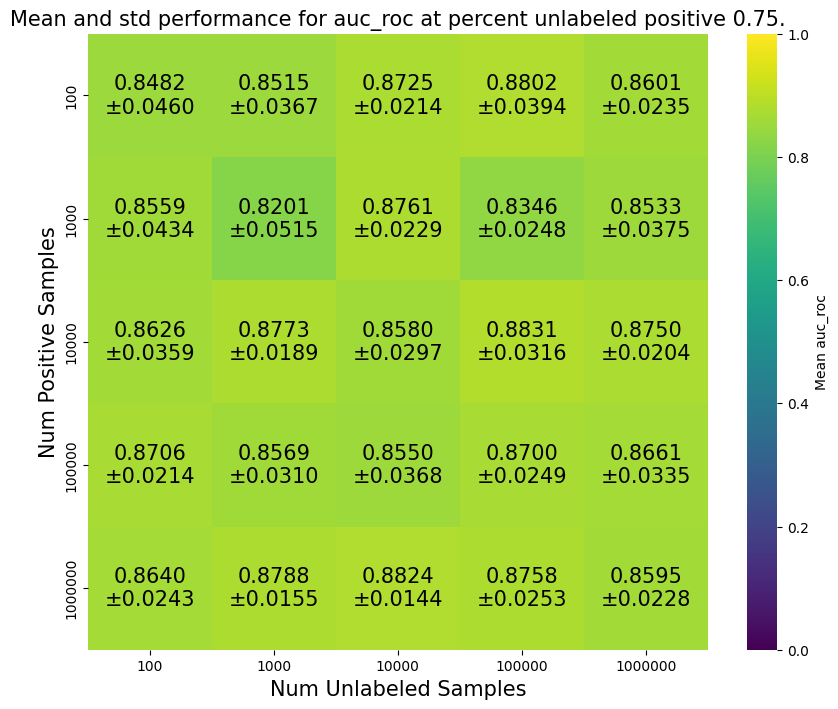

/var/folders/mj/000gxq2x64vb9t9p3frbt_0c0000gn/T/ipykernel_21571/2450750814.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numbers[ii] = eval_df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'{metric}_{ii}'][0]


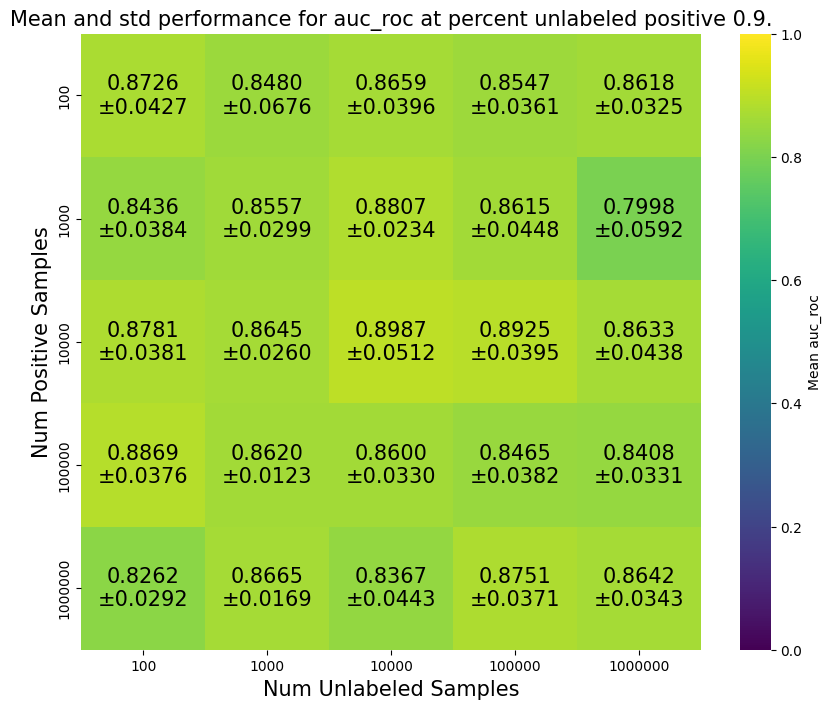

/var/folders/mj/000gxq2x64vb9t9p3frbt_0c0000gn/T/ipykernel_21571/2450750814.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numbers[ii] = eval_df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'{metric}_{ii}'][0]


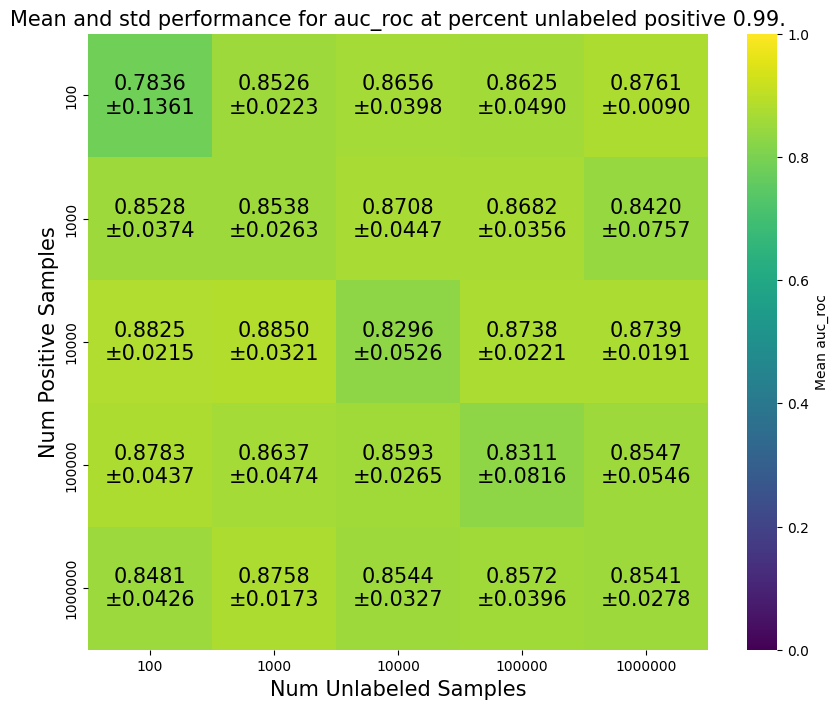

/var/folders/mj/000gxq2x64vb9t9p3frbt_0c0000gn/T/ipykernel_21571/2450750814.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numbers[ii] = eval_df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'{metric}_{ii}'][0]


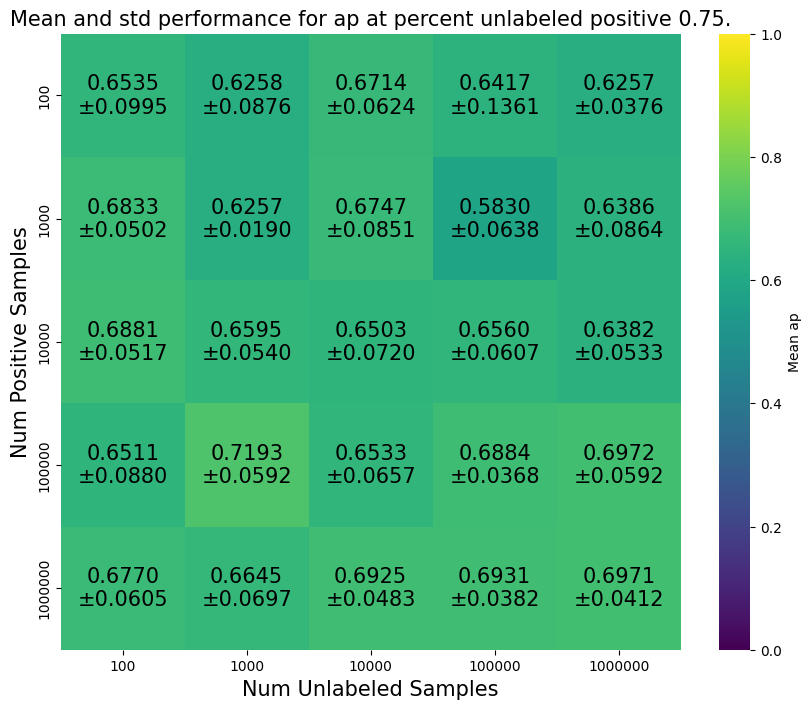

/var/folders/mj/000gxq2x64vb9t9p3frbt_0c0000gn/T/ipykernel_21571/2450750814.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numbers[ii] = eval_df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'{metric}_{ii}'][0]


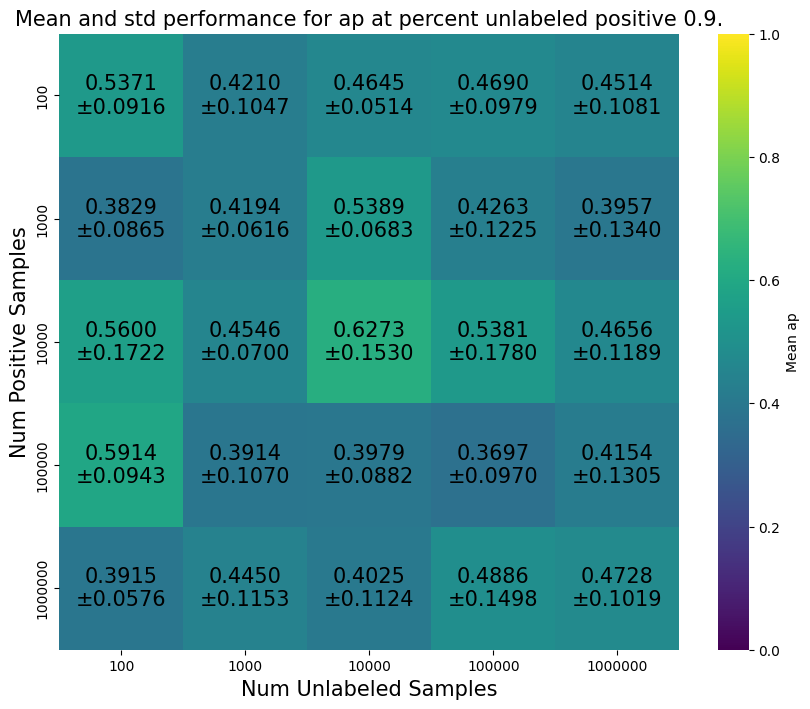

/var/folders/mj/000gxq2x64vb9t9p3frbt_0c0000gn/T/ipykernel_21571/2450750814.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numbers[ii] = eval_df.loc[f'{num_positive_samples}_{num_unlabeled_samples}_{percent_unlabeled_positive}', f'{metric}_{ii}'][0]


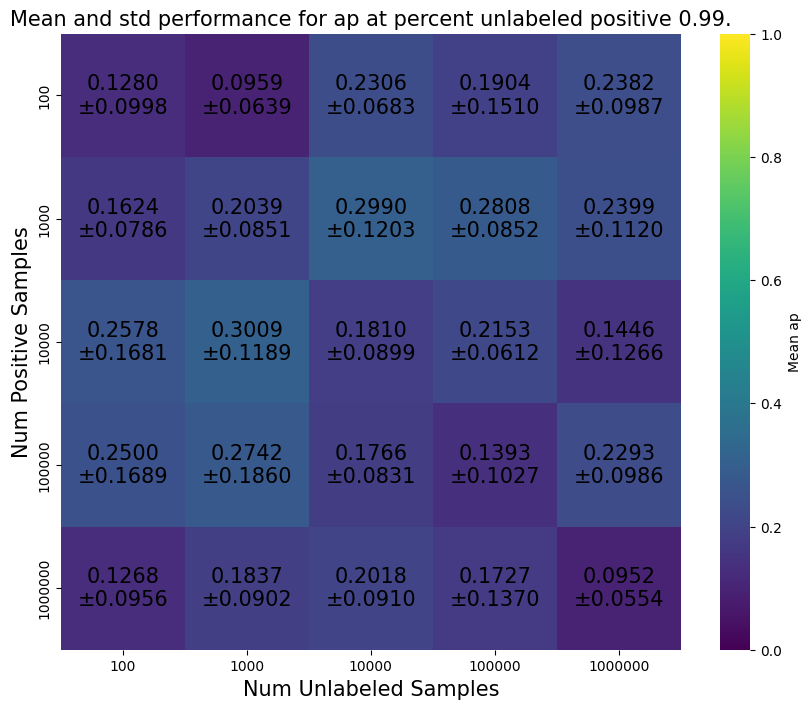

In [9]:
plot_heatmap(5, 0.75, 'auc_roc')
plot_heatmap(5, 0.9, 'auc_roc')
plot_heatmap(5, 0.99, 'auc_roc')
plot_heatmap(5, 0.75, 'ap')
plot_heatmap(5, 0.9, 'ap')
plot_heatmap(5, 0.99, 'ap')

In [10]:
display_generator_samples(5, 10**6, 10**6, 0.99, 5)

1000000_1000000_0.99_0


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.568746,0.466010,0.657189,0.302124,0.336291
1,0.565018,0.448784,0.638709,0.329615,0.381029
2,0.560942,0.455535,0.659689,0.298911,0.323980
3,0.550275,0.470641,0.646942,0.324518,0.352198
4,0.542554,0.454891,0.637879,0.341974,0.386340


1000000_1000000_0.99_1


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.366418,0.593026,0.461079,0.504859,0.469122
1,0.378640,0.616025,0.458628,0.509305,0.477303
2,0.385546,0.602444,0.474284,0.523696,0.489086
3,0.386307,0.607454,0.462904,0.518778,0.489373
4,0.359606,0.608670,0.471775,0.527362,0.473946


1000000_1000000_0.99_2


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.279542,0.133731,0.482215,0.311033,0.754685
1,0.360051,0.216299,0.458259,0.352536,0.652669
2,0.355243,0.176697,0.497067,0.336590,0.680974
3,0.435776,0.292162,0.498039,0.411581,0.573556
4,0.156980,0.060369,0.353571,0.224599,0.842798


1000000_1000000_0.99_3


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.388047,0.434062,0.452046,0.617376,0.586340
1,0.391619,0.409962,0.451379,0.578236,0.564845
2,0.386385,0.397695,0.454641,0.581877,0.557689
3,0.388120,0.410084,0.454270,0.554145,0.552447
4,0.422271,0.395761,0.434020,0.530983,0.557739


1000000_1000000_0.99_4


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.393930,0.650111,0.343831,0.321083,0.549095
1,0.442466,0.599784,0.393420,0.390309,0.520575
2,0.420604,0.630792,0.420643,0.322687,0.513599
3,0.525189,0.556767,0.478112,0.459617,0.510588
4,0.452555,0.692631,0.308740,0.227311,0.488185


In [11]:
display_generator_samples(5, 10**5, 10**3, 0.75, 5)

100000_1000_0.75_0


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.605029,0.625591,0.460019,0.515518,0.346304
1,0.531336,0.638414,0.464360,0.525304,0.396485
2,0.583301,0.581834,0.450142,0.503666,0.404510
3,0.488353,0.621794,0.437173,0.555600,0.454182
4,0.604665,0.638244,0.432646,0.535859,0.364391


100000_1000_0.75_1


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.521173,0.582515,0.506286,0.504011,0.445917
1,0.463813,0.600344,0.569955,0.472594,0.434556
2,0.494833,0.568175,0.526633,0.494835,0.474745
3,0.484139,0.579950,0.535194,0.470562,0.409710
4,0.489581,0.571582,0.513591,0.500012,0.414157


100000_1000_0.75_2


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.515361,0.475256,0.491299,0.506243,0.502983
1,0.546430,0.464671,0.472691,0.527297,0.494149
2,0.529472,0.478021,0.458338,0.544020,0.489742
3,0.541326,0.434964,0.492728,0.554993,0.457780
4,0.532536,0.464220,0.486885,0.528458,0.498929


100000_1000_0.75_3


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.752585,0.359654,0.394239,0.426975,0.821187
1,0.623669,0.461085,0.467852,0.516492,0.641073
2,0.762213,0.381955,0.371615,0.460786,0.808888
3,0.662930,0.435079,0.466207,0.529934,0.673933
4,0.693947,0.393702,0.404731,0.473440,0.756281


100000_1000_0.75_4


,function_id,function_parameters.amount,starting_state.balance,final_state.balance,transaction_return.success
0,0.525797,0.559216,0.478422,0.489827,0.446422
1,0.494976,0.561341,0.466147,0.504859,0.450661
2,0.450833,0.595969,0.423561,0.487278,0.402278
3,0.526345,0.561800,0.470814,0.488066,0.440899
4,0.480822,0.614340,0.495095,0.502653,0.459632


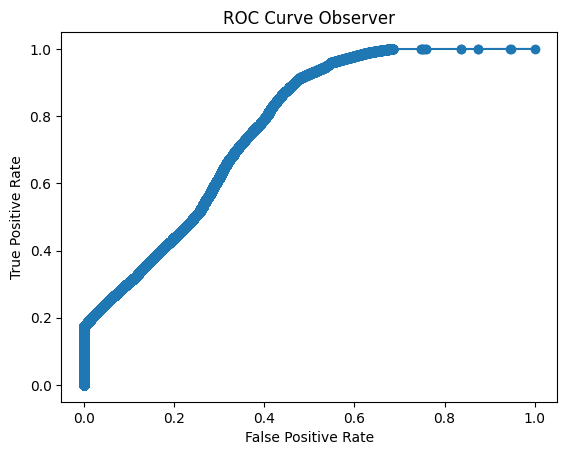

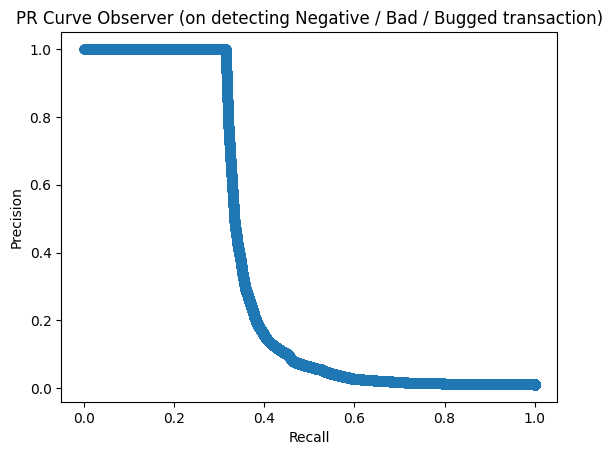

In [12]:
display_curves(10**5, 10**6, 0.99, 0)